# RS evaluation with a custom response model

This tutorial shows how to create custom response function and use it in Sim4Rec.


### Users
5000 anonymous users

### Items
100 items

### Response function
Users are more likely to choose the most popular items.


## Imports and preparations

In [1]:
import os
import sys
os.environ["JAVA_HOME"] = "/home/jovyan/volodkevich/smm_pomi_pylot/av_env39_smm/lib/jvm"
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["OMP_NUM_THREADS"] = "32"
os.environ["NUMBA_NUM_THREADS"] = "4"

In [5]:
import random
import time

import numpy as np
import pandas as pd
import warnings

from pyspark import SparkConf
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
import pyspark.sql.functions as sf
from replay.models import UCB

from experiments.response_models.utils import plot_metric, calc_metric
from sim4rec.modules import RealDataGenerator
from sim4rec.modules import Simulator
from sim4rec.response import BernoulliResponse,  ActionModelTransformer

warnings.filterwarnings("ignore") 

In [6]:
# path to spark tmp folder and simulator checkpoints
SPARK_LOCAL_DIR = './tmp/task_1'
CHECKPOINT_DIR = './tmp/task_1_checkpoints'

In [7]:
%%bash -s "$CHECKPOINT_DIR" "$SPARK_LOCAL_DIR"
# simulator saves the interaction history between users and recommender system
# to rerun the simulation cycle or begin a new one, clear the directory or use another CHECKPOINT_DIR
rm -rf $1 $2

In [8]:
NUM_THREADS = 4

spark = SparkSession.builder\
    .appName('simulator')\
    .master(f'local[{NUM_THREADS}]')\
    .config('spark.sql.shuffle.partitions', f'{NUM_THREADS * 3}')\
    .config('spark.default.parallelism', f'{NUM_THREADS * 3}')\
    .config('spark.driver.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.executor.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.local.dir', SPARK_LOCAL_DIR)\
    .getOrCreate()

spark.sparkContext.setLogLevel('ERROR')

24/08/12 13:41:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/12 13:41:25 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
24/08/12 13:41:26 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [9]:
NUM_USERS = 5000
NUM_ITEMS = 100 # number of recommendations generated by RS per user per one iteration
K = 5 # number of iterations
NUM_ITER = 5
SEED = 1234
np.random.seed(SEED)

## Data

In [10]:
users = spark.createDataFrame([[x] for x in range(NUM_USERS * 2)], schema=["user_idx"])
items = spark.createDataFrame([[x] for x in range(NUM_ITEMS * 2)], schema=["item_idx"])
items.count()

200

In [11]:
items.limit(2).toPandas()

,item_idx
0,0
1,1


In [12]:
item_generator = RealDataGenerator(label='items_real', seed=SEED)
user_generator = RealDataGenerator(label='users_real', seed=SEED)

item_generator.fit(items)
user_generator.fit(users)

item_generator.generate(NUM_ITEMS)
user_generator.generate(NUM_USERS)
item_generator.getDataSize()

100

# One iteration of simulation cycle step by step

## (1) Choise of users

In [13]:
user_generator.sample(0.1).count()

504

## (2) Choise of items
During the simulation cycle all 100 items will be available at each iteration.

## (3) Initialization of recommender model

### Baseline

In [15]:
# RePlay model should be fitted on historic data before it can be refitted in cycle
# Let's assume we had one interaction for simplicity
model = UCB(sample=True, seed=SEED, exploration_coef=0.1)
model.fit(
    log=users.limit(1).crossJoin(items.limit(1)).withColumn("relevance", sf.lit(1))
)
pred = model.predict(log=None, users=users.limit(2), items=items, k=2)
pred.limit(5).toPandas()

,user_idx,item_idx,relevance
0,0,54,0.005
1,0,155,0.005
2,1,10,0.005
3,1,16,0.005


## (4) Response Function

The response function in this tutorial is very simple. The response is binary, response == 1 means the user bought the item.  
The probability of response is one tenth of the last digit of an `item_idx`. The response function is constant over time.

Response function gets dataframe with columns `user_idx`, `item_idx`, `relevance`, and returns dataframe with columns `user_idx`, `item_idx`, `relevance`, `response`, adding the response column to the initial ones. If the initial dataframe had some other columns, these will also be returned.

In [17]:
items.limit(5).withColumn(
    "response_proba", (sf.col("item_idx") % sf.lit(10)) / sf.lit(10)
).toPandas()

,item_idx,response_proba
0,0,0.0
1,1,0.1
2,2,0.2
3,3,0.3
4,4,0.4


In [18]:
class PopBasedTransformer(ActionModelTransformer):
    def __init__(
        self,
        inputCol: str = None,
        outputCol: str = None,
    ):
        """
        Class for the response function. 
        The probability of response is one tenth of the last digit of an item_idx.
        :param inputCol: Name of the item_id column
        :param outputCol: Name of the response probability column
        :returns: dataframe with response_proba col
        """
        self.inputCol = inputCol
        self.outputCol = outputCol

    def _transform(self, dataframe):
        return dataframe.withColumn(
            self.outputCol, (sf.col(self.inputCol) % sf.lit(10)) / sf.lit(10)
        )

Example how the response is generated for user-item pair

In [19]:
popularity_model = PopBasedTransformer(inputCol="item_idx", outputCol="response_proba")
br = BernoulliResponse(inputCol="response_proba", outputCol="response", seed=SEED)
response_pipeline = Pipeline(stages=[popularity_model,br])
response_model = response_pipeline.fit(items)
test_response = response_model.transform(pred)
test_response.limit(5).toPandas()

,user_idx,item_idx,relevance,response_proba,response
0,0,54,0.005,0.4,0
1,0,155,0.005,0.5,0
2,1,10,0.005,0.0,0
3,1,16,0.005,0.6,1


## (5) Fitting of new recommender model

After receiving responses to recommendations, we can use this information to update the recommender model. To do this, we should rename column `response` to `relevance`.

In [20]:
new_log = test_response.drop("relevance", "response_proba").withColumnRenamed(
    "response", "relevance"
)
new_log.limit(5).toPandas()

,user_idx,item_idx,relevance
0,0,54,0
1,0,155,0
2,1,10,0
3,1,16,1


In [21]:
model.fit(log=new_log)
model.item_popularity.limit(5).toPandas()

,item_idx,relevance
0,54,0.37233
1,155,0.37233
2,10,0.37233
3,16,1.37233


## (6) Quality of recommendations

Quality is the mean number of positive responses per user.

In [22]:
calc_metric(test_response)

0.5

# Training the model in the simulator

In [23]:
%%bash -s "$CHECKPOINT_DIR"
rm -rf $1

## Simulator initialization

In [24]:
user_generator.initSeedSequence(SEED)
item_generator.initSeedSequence(SEED)

sim = Simulator(
    user_gen=user_generator,
    item_gen=item_generator,
    data_dir=f'{CHECKPOINT_DIR}/pipeline',
    user_key_col='user_idx',
    item_key_col='item_idx',
    spark_session=spark
)

### Check that the format is correct

In [25]:
pred = model.predict(log=None, users=users.limit(10), items=items, k=K)

assert pred.columns == ["user_idx", "item_idx", "relevance"]
assert (
    pred.groupBy("user_idx")
    .agg(sf.countDistinct("item_idx").alias("num_items"))
    .filter(sf.col("num_items") == sf.lit(K))
    .count()
    == 10
)
assert (
    pred.groupBy("user_idx")
    .agg(sf.count("item_idx").alias("num_items"))
    .filter(sf.col("num_items") == sf.lit(K))
    .count()
    == 10
)

## Response function initialization

In [26]:
response_model = response_pipeline.fit(items)

## Simulation cycle

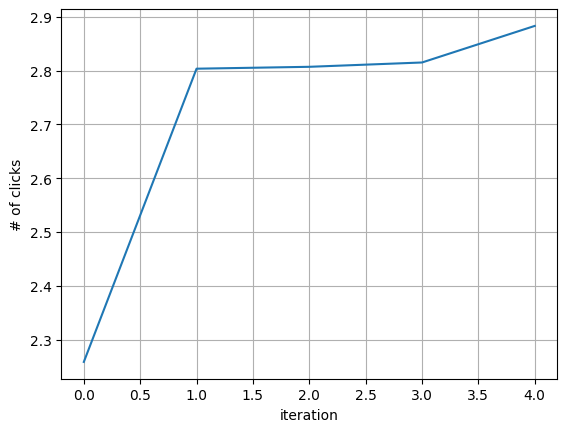

Iteration 4 finished in 51.38935136795044 sec.


In [27]:
metrics = []
for i in range(NUM_ITER):
    print(f"Iteration {i} started")
    iter_time = time.time()
    # visiting users
    current_users = sim.sample_users(0.1).cache()
    # history of interactions
    log = sim.get_log(users)
    # getting recommendations from the recommender system
    recs = model.predict(
        log=log, k=5, users=current_users, items=items, filter_seen_items=False
    )
    # getting responses
    true_resp = sim.sample_responses(
        recs_df=recs,
        user_features=current_users,
        item_features=items,
        action_models=response_model,
    )
    # update the interaction history
    sim.update_log(true_resp, iteration=i)
    # measure quality
    metrics.append(calc_metric(true_resp))
    # refitting the model
    model._clear_cache()
    train_log = sim.log
    model.fit(
        log=train_log.select("user_idx", "item_idx", "response").withColumnRenamed(
            "response", "relevance"
        )
    )

    current_users.unpersist()
    if log is not None:
        log.unpersist()
    recs.unpersist()
    true_resp.unpersist()
    train_log.unpersist()

    plot_metric(metrics)
    print(f"Iteration {i} finished in {time.time() - iter_time} sec.")

In [28]:
sim.log.filter(sf.col("__iter") == 1).show(2)

+--------+--------+--------------------+--------------+--------+------+
|item_idx|user_idx|           relevance|response_proba|response|__iter|
+--------+--------+--------------------+--------------+--------+------+
|      36|      11|0.008283327970530089|           0.6|       0|     1|
|       9|      11|0.008227152148671986|           0.9|       1|     1|
+--------+--------+--------------------+--------------+--------+------+
only showing top 2 rows



# Final prediction

In [29]:
recs = model.predict(
    log=sim.log,
    k=K,
    users=users,
    items=items,
    filter_seen_items=False
).cache()

In [30]:
# responses
true_resp = sim.sample_responses(
    recs_df=recs, user_features=users, item_features=items, action_models=response_model
).cache()

# quality
print(
    f"Average number of items purchased per user after model training = {calc_metric(true_resp)}"
)

Average number of items purchased per user after model training = 2.8967


In [31]:
recs.unpersist()
true_resp.unpersist()

DataFrame[item_idx: int, user_idx: int, relevance: double, response_proba: double, response: int]

In [32]:
model.item_popularity.orderBy(sf.col('relevance').desc()).show()

+--------+------------------+
|item_idx|         relevance|
+--------+------------------+
|     179|1.0470321553521966|
|      79|1.0262914981136138|
|      59|1.0255267790081104|
|     169|1.0215844167045316|
|      39|1.0108198940700257|
|     119| 1.010309437787467|
|     149|1.0076124381846867|
|     139|0.9972037528118562|
|     129|0.9956026741489598|
|      19|0.9932687144919815|
|       9|0.9932687144919815|
|     189|0.9926462656346515|
|      99|0.9913506408893762|
|     188|0.9836770994776983|
|      28|0.9802395297782651|
|     109|0.9777765802136702|
|      29|0.9751056083557399|
|      49|0.9689038364412762|
|     159|0.9672559122960707|
|     199|0.9639047251239821|
+--------+------------------+
only showing top 20 rows

